### LGBM/XGB approach

The goal is using the gradient boosting techniques mentioned above to create a model with decent accuracy.

The libraries have built-in solutions for imbalanced data, and as far as scaling goes, for this type of modelling it is not required.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [2]:
df = pd.read_csv('bc_re.csv', index_col=0)
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Avg_Utilization_Ratio
CLIENTNUM,,,,,,,,,,,,,,,,,,
768805383,0,45,0,3,0,1,2.0,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,0.061
818770008,0,49,1,5,0,0,1.0,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,0.105
713982108,0,51,0,3,0,1,3.0,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,0.000
769911858,0,40,1,4,0,0,1.0,0,34,3,4,1,3313.0,2517,796.0,1.405,1171,0.760
709106358,0,40,0,3,0,1,2.0,0,21,5,1,0,4716.0,0,4716.0,2.175,816,0.000


In [3]:
y = df.pop('Attrition_Flag')

In [4]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

I should, in this case, implement a solution with some kind of random search. Since  sklearn's RandomizedSearchCV does not work that well with LightGBM, I will try to implement a custom solution (with a load of inspiration from the internet, of course)

But first of all, let's see where I can get doing nothing and straight up using the lgbm dataset for training.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 1000)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 1000)

In [7]:
for i in [X_train,X_valid,X_test]:
    print(len(i))

8127
1000
1000


In [8]:
first_train = lgb.Dataset(X_train, label = y_train)

In [9]:
first_valid = lgb.Dataset(X_valid, label = y_valid)

In [19]:
params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt' #default
params['objective'] = 'binary'
params['metric'] = 'auc' #the dataset is imbalanced
params['max_depth'] = 10
params['num_threads'] = -1
params['num_leaves'] = 31 #default
params['bagging'] = 1

In [20]:
first_clf = lgb.train(params,
                      first_train,
                      100,
                      valid_sets = [first_valid],
                      early_stopping_rounds = 5,
                      verbose_eval = 5)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1293, number of negative: 6834
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 8127, number of used fea

In [31]:
#confusion matrix function
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap = 'Greens')
    plt.title('Confusion matrix at probability: {:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    print('No churn detected (True Negatives): ', cm[0][0])
    print('Churn Incorrectly Detected (False Positives): ', cm[0][1])
    print('Churn Missed (False Negatives): ', cm[1][0])
    print('Churn Detected (True Positives): ', cm[1][1])
    print('Total Churns: ', np.sum(cm[1]))
    
    print('Model precision: ', cm[1][1]/(cm[1][1]+cm[0][1]))
    print('Model recall: ', cm[1][1]/(cm[1][1]+cm[1][0]))
    print('Model accuracy: ', (cm[1][1]+cm[0][0])/len(labels))

In [22]:
first_pred = first_clf.predict(X_test)

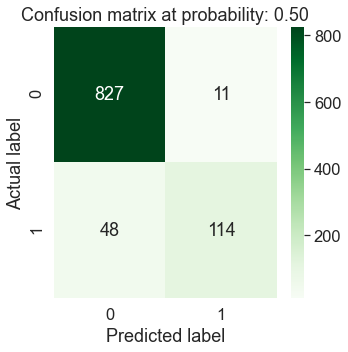

No churn detected (True Negatives):  827
Churn Incorrectly Detected (False Positives):  11
Churn Missed (False Negatives):  48
Churn Detected (True Positives):  114
Total Churns:  162
Model precision:  0.912
Model recall:  0.7037037037037037
Model accuracy:  0.941


In [32]:
plot_cm(y_test, first_pred)

Without much tweaking I was able to reach an accuracy of 94%, which is not good, I would like to get close to 98 or 99.

## Will SMOTE help?

In [37]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [38]:
from collections import Counter

In [50]:
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
under = RandomUnderSampler(sampling_strategy = 1, random_state = 42)
seq = [('over',over),('under',under)]
pipeline = Pipeline(steps=seq)

X_train_bal, y_train_bal = pipeline.fit_resample(X_train, y_train)
X_valid_bal, y_valid_bal = pipeline.fit_resample(X_valid, y_valid)

print('Training size:',len(X_train_bal))
print('Train positives', Counter(y_train_bal)[1])
print('Valid size:', len(X_valid_bal))
print('Valid positives', Counter(y_valid_bal)[1])

Training size: 6834
Train positives 3417
Valid size: 828
Valid positives 414


In [51]:
#now I should have the classes 50:50. Will that help with the basic lgbm model?
first_train_bal = lgb.Dataset(X_train_bal, label = y_train_bal)
first_valid_bal = lgb.Dataset(X_valid_bal, label = y_valid_bal)

In [53]:
second_clf = lgb.train(params,
                      first_train_bal,
                      100,
                      valid_sets = [first_valid_bal],
                      early_stopping_rounds = 5,
                      verbose_eval = 5)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3417, number of negative: 3417
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 6834, number of used fea

The AUC has gone up slightly. What about the general performance? I will use the original imbalanced test set

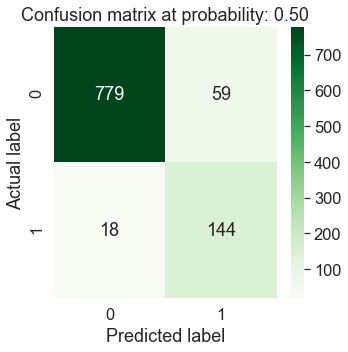

No churn detected (True Negatives):  779
Churn Incorrectly Detected (False Positives):  59
Churn Missed (False Negatives):  18
Churn Detected (True Positives):  144
Total Churns:  162
Model precision:  0.7093596059113301
Model recall:  0.8888888888888888
Model accuracy:  0.923


In [54]:
second_pred = second_clf.predict(X_test)
plot_cm(y_test, second_pred)

## Balancing or not?

That depends on the particular situation. I have increased recall and reduced precision (typical tradeoff), the overall accuracy has gone down slightly. Also SMOTE might not be the best method since it does not perform well on datasets with many features.

What's more important though? Recall or precision? 

Precision over recall - means we prefer to reduce the amounts of false positives.

Recall over precision - means we prefer to reduce FN. That should be this case since we want to prevent people from leaving.

The LGBM algorithms are basically prepared to face imbalanced data, thus it makes sense that the overall accuracy was rather hurt by this step. The second model is better for our use case, even though the accuracy is lower. 

## Custom parameter search

In [55]:
from scipy.stats import randint as sp_randint
from random import choice
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [56]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(df, y)

5

In [71]:
from sklearn.metrics import f1_score

n_iters = 10000
top_n = 5


In [72]:
f1_mean = []
f1_std = []
roc_auc_mean = []
roc_auc_std = []
dict_list = []

In [60]:
import time

In [ ]:
print("Random search commencing...")
print('')

start = time.time()
for i in range(0, n_iters):
    skf_split = skf.split(df, y)
    param_dist = {'num_leaves': choice([27,31,61,81,127,197,245,275,302]),
                 'bagging_fraction':choice([0.5,0.7,0.8,0.9]),
                 'learning_rate': choice([0.001,0.005,0.01,0.03,0.05,0.1,0.3,0.5]),
                 'is_unbalance': choice([True, False]),
                 'max_bin': choice([3, 5, 10, 12, 18, 20, 22]),
                 'boosting_type' : choice(['gbdt', 'dart']),
                 'bagging_freq': choice([3, 9, 11, 15, 17, 23, 31]),
                 'max_depth': choice([3, 5, 6, 7, 9, 11, 13, 15]),
                 'feature_fraction': choice([0.5, 0.7, 0.8, 0.9]),
                 'lambda_l1': choice([0, 10, 20, 30, 40]),
                 'objective': 'binary',
                 'metric': 'auc'}
    roc_1 = []
#    f1_1 = []
    ### TRAINING ###
    print('Cycle {}'.format(i+1))
    for train_index, test_index in skf_split:
        X_train = df.iloc[train_index]
        y_train = y.iloc[train_index]
        
        X_val = df.iloc[test_index]
        y_val =y.iloc[test_index]
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_val = lgb.Dataset(X_val, y_val, reference = lgb_train)
        
        gbm = lgb.train(param_dist,
                       lgb_train,
                       num_boost_round = 10,
                       valid_sets = lgb_val,
                       early_stopping_rounds = 5,
                       verbose_eval = 5)
        ### PREDICTING ###
        y_pred = gbm.predict(X_val, num_iteration = gbm.best_iteration)
        roc = roc_auc_score(y_val, y_pred)
        roc_1.append(roc)
#        f1 = f1_score(y_val, y_pred,zero_division=1)
#        f1_1.append(f1)
    
    roc_array = np.asarray(roc_1)
#    f1_array = np.asarray(f1_1)
    
#    f1_mean.append(f1_array.mean())
#    f1_std.append(f1_array.std())
    roc_auc_mean.append(roc_array.mean())
    roc_auc_std.append(roc_array.std())
    dict_list.append(param_dist)
    
results_pd = pd.DataFrame({'roc_auc_mean':roc_auc_mean,
                          'roc_auc_std':roc_auc_std,
                          'parameters': dict_list})
results_pd.sort_values('roc_auc_mean', ascending = False, axis = 0, inplace=True)
top_pd = results_pd.head(top_n)

for i in range(0, top_n):
    print ("Model with rank {}".format(i+1))
    print ("Mean roc_auc score %.5f (std: %.5f)" % (top_pd['roc_auc_mean'].values[i], top_pd['roc_auc_std'].values[i]))
    print ("Parameters:", top_pd['parameters'].values[i])
    print ("")

        
end = time.time()

print('This loop took exactly {} seconds'.format(end-start))

### Original output
Cell removed for the sake of saving space

Model with rank 1<br>
Mean roc_auc score 0.92252 (std: 0.05961)<br>
Parameters: {'num_leaves': 197, 'bagging_fraction': 0.7, 'learning_rate': 0.3, 'is_unbalance': False, 'max_bin': 20, <br>'boosting_type': 'gbdt', 'bagging_freq': 11, 'max_depth': 5, 'feature_fraction': 0.5, 'lambda_l1': 0, <br>'objective': 'binary', 'metric': 'auc'}

Model with rank 2<br>
Mean roc_auc score 0.91945 (std: 0.05953)<br>
Parameters: {'num_leaves': 275, 'bagging_fraction': 0.9, 'learning_rate': 0.5, 'is_unbalance': True, 'max_bin': 20, <br>'boosting_type': 'gbdt', 'bagging_freq': 17, 'max_depth': 5, 'feature_fraction': 0.5, 'lambda_l1': 20,<br> 'objective': 'binary', 'metric': 'auc'}

Model with rank 3<br>
Mean roc_auc score 0.91807 (std: 0.06835)<br>
Parameters: {'num_leaves': 27, 'bagging_fraction': 0.8, 'learning_rate': 0.5, 'is_unbalance': True, 'max_bin': 20, <br>'boosting_type': 'gbdt', 'bagging_freq': 17, 'max_depth': 9, 'feature_fraction': 0.5, 'lambda_l1': 0,<br> 'objective': 'binary', 'metric': 'auc'}

Model with rank 4<br>
Mean roc_auc score 0.91706 (std: 0.07287)<br>
Parameters: {'num_leaves': 275, 'bagging_fraction': 0.7, 'learning_rate': 0.5, 'is_unbalance': False, 'max_bin': 22, <br>'boosting_type': 'gbdt', 'bagging_freq': 15, 'max_depth': 6, 'feature_fraction': 0.5, 'lambda_l1': 0,<br> 'objective': 'binary', 'metric': 'auc'}

Model with rank 5<br>
Mean roc_auc score 0.91703 (std: 0.07758)<br>
Parameters: {'num_leaves': 302, 'bagging_fraction': 0.5, 'learning_rate': 0.5, 'is_unbalance': False, 'max_bin': 22, <br>'boosting_type': 'gbdt', 'bagging_freq': 15, 'max_depth': 3, 'feature_fraction': 0.9, 'lambda_l1': 0, <br>'objective': 'binary', 'metric': 'auc'}

This loop took exactly 2100.234271287918 seconds

In [75]:
#using the best params on the test set
params_cv = {'num_leaves': 197,
             'bagging_fraction': 0.7,
             'learning_rate': 0.3,
             'is_unbalance': False,
             'max_bin': 20,
             'boosting_type': 'gbdt',
             'bagging_freq': 11,
             'max_depth': 5,
             'feature_fraction': 0.5,
             'lambda_l1': 0,
             'objective': 'binary',
             'metric': 'auc'}

third_train = lgb.Dataset(X_train, label = y_train)
third_valid = lgb.Dataset(X_valid, label = y_valid)

third_clf = lgb.train(params_cv,
                      third_train,
                      num_boost_round = 10,
                      valid_sets = [third_valid],
                      early_stopping_rounds = 5,
                      verbose_eval = 5)

[LightGBM] [Info] Number of positive: 1302, number of negative: 6800
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 8102, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160701 -> initscore=-1.653021
[LightGBM] [Info] Start training from score -1.653021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	vali

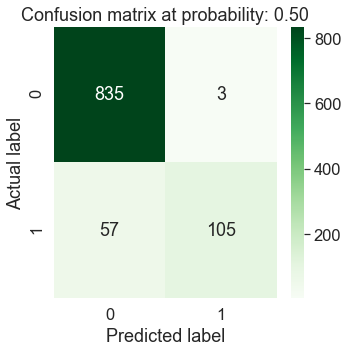

No churn detected (True Negatives):  835
Churn Incorrectly Detected (False Positives):  3
Churn Missed (False Negatives):  57
Churn Detected (True Positives):  105
Total Churns:  162
Model precision:  0.9722222222222222
Model recall:  0.6481481481481481
Model accuracy:  0.94


In [76]:
cv_pred = third_clf.predict(X_test)
plot_cm(y_test, cv_pred)

## Param search for balanced data

Using custom GridSearch helped to improve the precision and accuracy, which is nice, but if I want to aim for recall, I apparently need to balance the training set. Will that help, if I perform the above used Grid Search again with the equally balanced data? The result will be affected by the possibly not very well chosen SMOTE method, but I'm curious enough to try it.

In [77]:
n_iters = 10000
top_n = 5
roc_auc_mean = []
roc_auc_std = []
dict_list = []

In [78]:
big_X = pd.concat([X_train_bal,X_valid_bal])
big_y = pd.concat([y_train_bal, y_valid_bal])
print(len(big_X),len(big_y))

7662 7662


In [ ]:
print("Random search commencing...")
print('')

start = time.time()
for i in range(0, n_iters):
    skf_split = skf.split(big_X, big_y)
    param_dist = {'num_leaves': choice([27,31,61,81,127,197,245,275,302]),
                 'bagging_fraction':choice([0.5,0.7,0.8,0.9]),
                 'learning_rate': choice([0.001,0.005,0.01,0.03,0.05,0.1,0.3,0.5]),
                 'is_unbalance': choice([True, False]),
                 'max_bin': choice([3, 5, 10, 12, 18, 20, 22]),
                 'boosting_type' : choice(['gbdt', 'dart']),
                 'bagging_freq': choice([3, 9, 11, 15, 17, 23, 31]),
                 'max_depth': choice([3, 5, 6, 7, 9, 11, 13, 15]),
                 'feature_fraction': choice([0.5, 0.7, 0.8, 0.9]),
                 'lambda_l1': choice([0, 10, 20, 30, 40]),
                 'objective': 'binary',
                 'metric': 'auc'}
    roc_1 = []
#    f1_1 = []
    ### TRAINING ###
    print('Cycle {}'.format(i+1))
    for train_index, test_index in skf_split:
        X_train = big_X.iloc[train_index]
        y_train = big_y.iloc[train_index]
        
        X_val = big_X.iloc[test_index]
        y_val = big_y.iloc[test_index]
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_val = lgb.Dataset(X_val, y_val, reference = lgb_train)
        
        gbm = lgb.train(param_dist,
                       lgb_train,
                       num_boost_round = 10,
                       valid_sets = lgb_val,
                       early_stopping_rounds = 5,
                       verbose_eval = 5)
        ### PREDICTING ###
        y_pred = gbm.predict(X_val, num_iteration = gbm.best_iteration)
        roc = roc_auc_score(y_val, y_pred)
        roc_1.append(roc)
#        f1 = f1_score(y_val, y_pred,zero_division=1)
#        f1_1.append(f1)
    
    roc_array = np.asarray(roc_1)
#    f1_array = np.asarray(f1_1)
    
#    f1_mean.append(f1_array.mean())
#    f1_std.append(f1_array.std())
    roc_auc_mean.append(roc_array.mean())
    roc_auc_std.append(roc_array.std())
    dict_list.append(param_dist)
    
results_pd_2 = pd.DataFrame({'roc_auc_mean':roc_auc_mean,
                          'roc_auc_std':roc_auc_std,
                          'parameters': dict_list})
results_pd_2.sort_values('roc_auc_mean', ascending = False, axis = 0, inplace=True)
top_pd_2 = results_pd_2.head(top_n)

for i in range(0, top_n):
    print ("Model with rank {}".format(i+1))
    print ("Mean roc_auc score %.5f (std: %.5f)" % (top_pd_2['roc_auc_mean'].values[i], top_pd_2['roc_auc_std'].values[i]))
    print ("Parameters:", top_pd_2['parameters'].values[i])
    print ("")

        
end = time.time()

print('This loop took exactly {} seconds'.format(end-start))

### Original output

Cell removed for the sake of saving space

Model with rank 1<br>
Mean roc_auc score 0.98323 (std: 0.00670)<br>
Parameters: {'num_leaves': 81, 'bagging_fraction': 0.9, 'learning_rate': 0.5, 'is_unbalance': False, 'max_bin': 20, <br>'boosting_type': 'gbdt', 'bagging_freq': 3, 'max_depth': 9, 'feature_fraction': 0.9, 'lambda_l1': 0,<br> 'objective': 'binary', 'metric': 'auc'}

Model with rank 2<br>
Mean roc_auc score 0.98297 (std: 0.00749)<br>
Parameters: {'num_leaves': 81, 'bagging_fraction': 0.9, 'learning_rate': 0.5, 'is_unbalance': False, 'max_bin': 22,<br> 'boosting_type': 'dart', 'bagging_freq': 11, 'max_depth': 13, 'feature_fraction': 0.9, 'lambda_l1': 0,<br> 'objective': 'binary', 'metric': 'auc'}

Model with rank 3<br>
Mean roc_auc score 0.98283 (std: 0.00695)<br>
Parameters: {'num_leaves': 81, 'bagging_fraction': 0.8, 'learning_rate': 0.5, 'is_unbalance': False, 'max_bin': 22,<br> 'boosting_type': 'dart', 'bagging_freq': 31, 'max_depth': 9, 'feature_fraction': 0.8, 'lambda_l1': 0,<br> 'objective': 'binary', 'metric': 'auc'}

Model with rank 4<br>
Mean roc_auc score 0.98257 (std: 0.00850)<br>
Parameters: {'num_leaves': 81, 'bagging_fraction': 0.9, 'learning_rate': 0.5, 'is_unbalance': True, 'max_bin': 22,<br> 'boosting_type': 'dart', 'bagging_freq': 31, 'max_depth': 13, 'feature_fraction': 0.7, 'lambda_l1': 0,<br> 'objective': 'binary', 'metric': 'auc'}

Model with rank 5<br>
Mean roc_auc score 0.98257 (std: 0.00653)<br>
Parameters: {'num_leaves': 31, 'bagging_fraction': 0.8, 'learning_rate': 0.5, 'is_unbalance': True, 'max_bin': 22,<br> 'boosting_type': 'dart', 'bagging_freq': 3, 'max_depth': 9, 'feature_fraction': 0.9, 'lambda_l1': 0,<br> 'objective': 'binary', 'metric': 'auc'}

This loop took exactly 1978.597252368927 seconds

In [80]:
params_cv_1 = {'num_leaves': 81,
               'bagging_fraction': 0.9,
               'learning_rate': 0.5,
               'is_unbalance': False,
               'max_bin': 20,
               'boosting_type': 'gbdt',
               'bagging_freq': 3,
               'max_depth': 9,
               'feature_fraction': 0.9,
               'lambda_l1': 0,
               'objective': 'binary',
               'metric': 'auc'}

fourth_train = lgb.Dataset(X_train_bal, label = y_train_bal)
fourth_valid = lgb.Dataset(X_valid_bal, label = y_valid_bal, reference = fourth_train)

fourth_clf = lgb.train(params_cv_1,
                      fourth_train,
                      num_boost_round = 10,
                      valid_sets = [fourth_valid],
                      early_stopping_rounds = 5,
                      verbose_eval = 5)


[LightGBM] [Info] Number of positive: 3417, number of negative: 3417
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 6834, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 5 rounds
[5]	valid_0's auc: 0.95149
[10]	valid_0's auc: 0.966306
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.966306


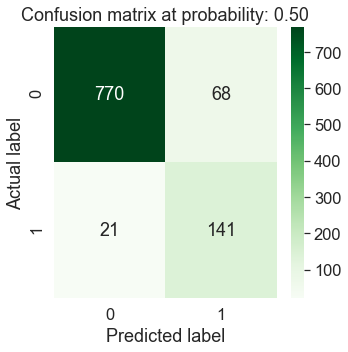

No churn detected (True Negatives):  770
Churn Incorrectly Detected (False Positives):  68
Churn Missed (False Negatives):  21
Churn Detected (True Positives):  141
Total Churns:  162
Model precision:  0.6746411483253588
Model recall:  0.8703703703703703
Model accuracy:  0.911


In [81]:
cv_pred_1 = fourth_clf.predict(X_test)
plot_cm(y_test, cv_pred_1)

### Feature importances

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

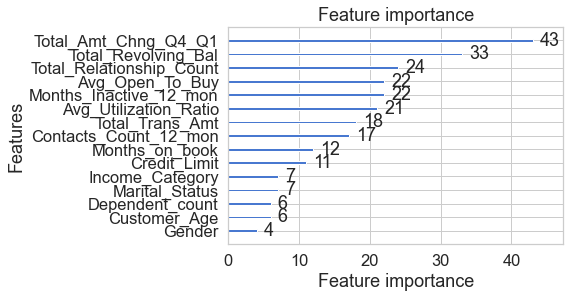

In [83]:
#for imbalanced CV model
lgb.plot_importance(third_clf)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

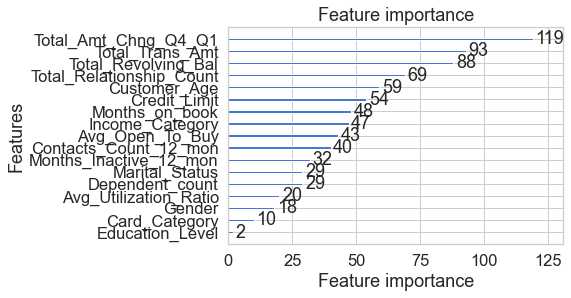

In [84]:
#for balanced model
lgb.plot_importance(fourth_clf)

## CONCLUSION

According to the feature importances, this data balancing technique (SMOTE) really does bend the algorithm's perception of the data and creates a bias which results in a quite different order of the feature importances. 

Note that SMOTE creates data according to dimensional similarity, in sparse spaces (many dimensions) this technique loses its performance. It does not take into account overlapping data of multiple classes and brings unwanted noise to the model.

Balanced data, however, improved the recall metric, which in this case is much more important than precision. As I am aiming to reduce the amount of people running away from our product, it is necessary to reduce false negatives as much as possible.

I consider this notebook to be finished and will be looking to improve the predictions using neural networks, which probably won't have enough data to boost the performance significantly, but we will see about that.